<a href="https://colab.research.google.com/github/coder-penguin/ML/blob/master/tutorial/keras_tutorial_imgext.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Sample code for image extraction with CNN

Load libraries

In [1]:
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt
import os
from PIL import Image, ImageOps
import subprocess
import glob
import matplotlib.image as mpimg

from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report
from sklearn.metrics import precision_recall_curve, roc_curve, roc_auc_score
from sklearn.externals import joblib

import tensorflow as tf
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, Activation, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, LearningRateScheduler, Callback
from tensorflow.keras.utils import plot_model, model_to_dot, to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, load_img, img_to_array
from tensorflow.keras import backend as K
from IPython.display import SVG

import shutil

from google.colab import drive
from google.colab import files

print(tf.__version__)

/usr/local/lib/python3.6/dist-packages/sklearn/externals/joblib/__init__.py:15: FutureWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=FutureWarning)


2.2.0-rc2


In [2]:
#check GPU
tf.test.gpu_device_name()

'/device:GPU:0'

Read data

In [5]:
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
!cp '/content/drive/My Drive/img_original.zip' .
!unzip -q 'img_original.zip'
!rm 'img_original.zip'

In [8]:
!ls ./img_original

fake  real


In [0]:
#get real image names
real_directry = './img_original/real/'
real_images = glob.glob(real_directry+'*.*')

In [0]:
def show_images(directry):
  images = glob.glob(directry+'*.*')
  plt.figure(figsize=(28, 12))
  for i in range(12):
    if i < len(images):
      plt.subplot(3, 4, i+1)
      img = mpimg.imread(images[i])
      imgplot = plt.imshow(img)

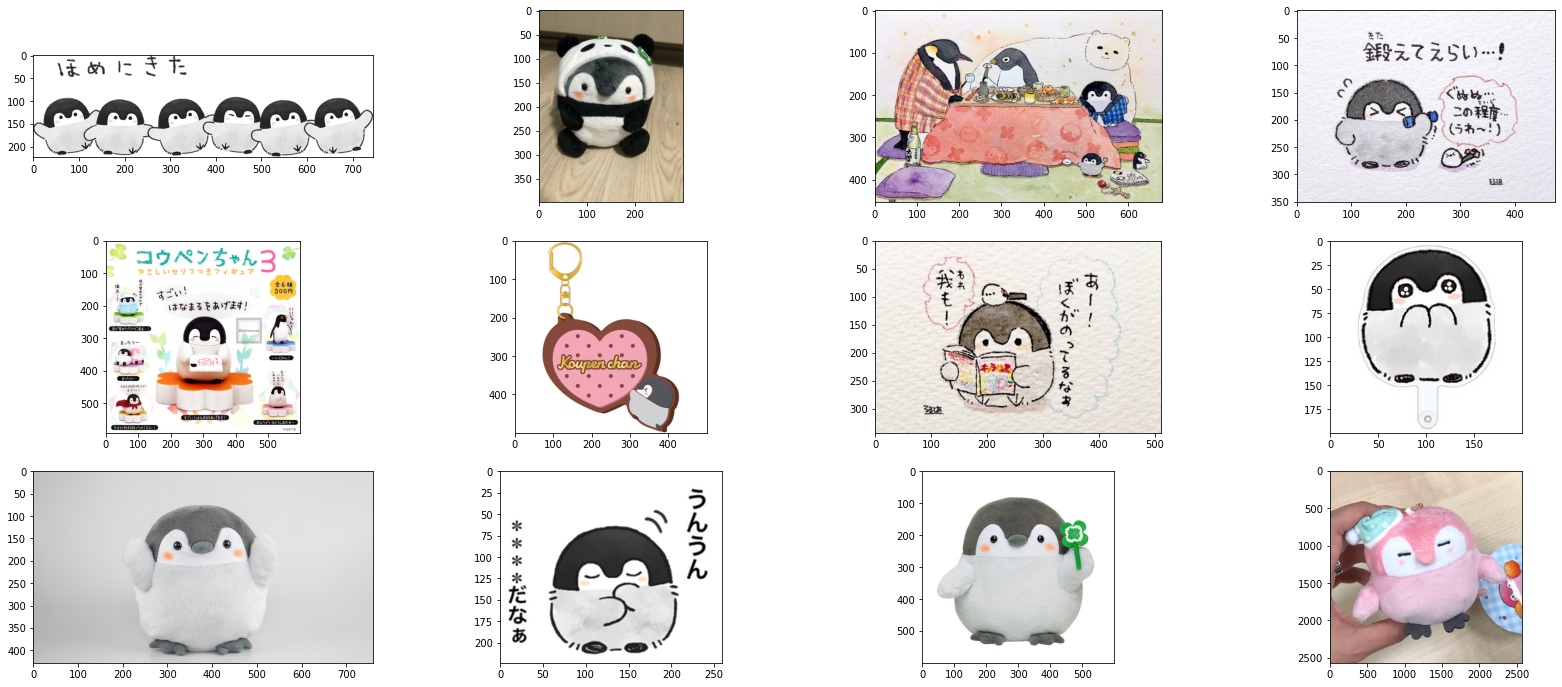

In [11]:
#show real images
show_images(real_directry)

In [0]:
#get fake image names
fake_directry = './img_original/fake/'
fake_images = glob.glob(fake_directry+'*.*')

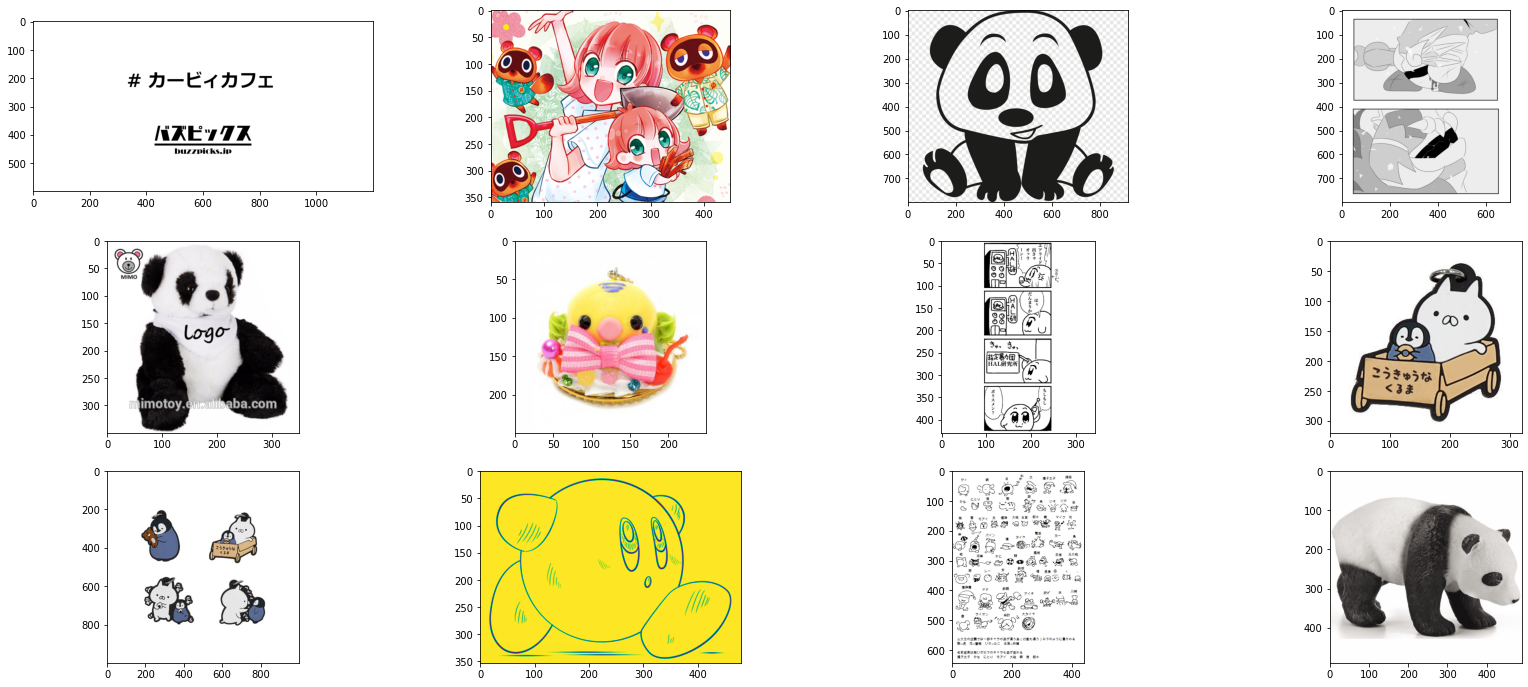

In [13]:
#show fake images
show_images(fake_directry)

###Split train and test data

In [0]:
!mkdir ./train
!mkdir ./train/real
!mkdir ./train/fake
!mkdir ./valid
!mkdir ./valid/real
!mkdir ./valid/fake

In [0]:
X_train_real, X_valid_real = train_test_split(real_images, test_size=0.2)
X_train_fake, X_valid_fake = train_test_split(fake_images, test_size=0.2)

In [0]:
def copy_files(file_list, destination):
  for file in file_list:
    subprocess.call('cp ' + file + ' ' + destination, shell=True)

In [0]:
copy_files(X_train_real, './train/real/')
copy_files(X_valid_real, './valid/real/')
copy_files(X_train_fake, './train/fake/')
copy_files(X_valid_fake, './valid/fake/')

Set generator

In [0]:
train_datagen = ImageDataGenerator(
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2,
        width_shift_range=0.1,
        height_shift_range=0.1,
        channel_shift_range=20.0,
        horizontal_flip=True,
        vertical_flip=False
        )

test_datagen = ImageDataGenerator(rescale=1./255)

In [19]:
train_generator = train_datagen.flow_from_directory(
        './train',
        target_size=(224, 224),
        batch_size=32,
        color_mode='grayscale',
        class_mode='binary')

validation_generator = test_datagen.flow_from_directory(
        './valid',
        target_size=(224, 224),
        batch_size=128,
        color_mode='grayscale',
        class_mode='binary',
        shuffle=False)

Found 434 images belonging to 2 classes.
Found 110 images belonging to 2 classes.


In [20]:
train_generator.class_indices

{'fake': 0, 'real': 1}

###Train model

In [0]:
def build_model():
  activation = 'elu'
  model = Sequential([
    Conv2D(32,3, input_shape=(224, 224, 1)),#filters, kernel_size
    Activation(activation),
    MaxPooling2D(pool_size=4),
    Conv2D(64,3),
    Activation(activation),
    MaxPooling2D(pool_size=4),
    Dropout(0.2),
    Conv2D(64,3),
    Activation(activation),
    MaxPooling2D(pool_size=4),
    Dropout(0.2),

    Flatten(),
    Dense(128),
    BatchNormalization(),
    Activation(activation),
    Dropout(0.5),
    Dense(32, activation=activation),
    Dense(1, activation='sigmoid')
  ], name='my_model')

  #compile
  loss = 'binary_crossentropy'
  optimizer = SGD(lr=0.05, nesterov=True)
  model.compile(loss=loss, optimizer=optimizer, metrics=['accuracy'])

  return model

In [0]:
model = build_model()

In [23]:
model.summary()

Model: "my_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 222, 222, 32)      320       
_________________________________________________________________
activation (Activation)      (None, 222, 222, 32)      0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 55, 55, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 53, 53, 64)        18496     
_________________________________________________________________
activation_1 (Activation)    (None, 53, 53, 64)        0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 13, 13, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 13, 13, 64)        0  

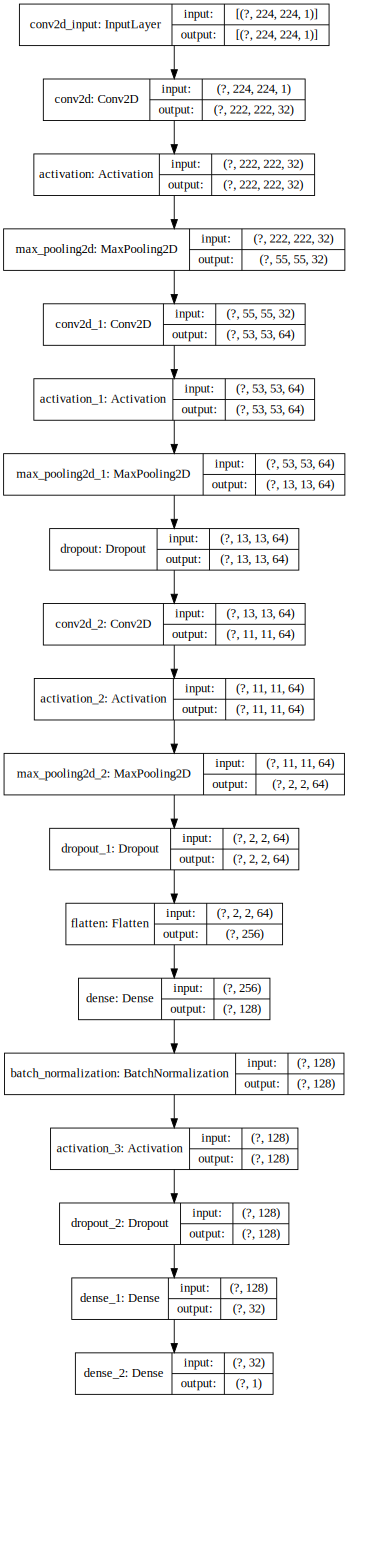

In [24]:
#show model
SVG(model_to_dot(model, show_shapes=True, dpi=65).create(prog='dot', format='svg'))

In [0]:
!mkdir log

In [0]:
class CosineAnnealingScheduler(Callback):
    def __init__(self, T_max, eta_max, eta_min=0):
        super(CosineAnnealingScheduler, self).__init__()
        self.T_max = T_max
        self.eta_max = eta_max
        self.eta_min = eta_min

    def on_epoch_begin(self, epoch, logs=None):
        if not hasattr(self.model.optimizer, 'lr'):
            raise ValueError('Optimizer must have a "lr" attribute.')
        lr = self.eta_min + (self.eta_max - self.eta_min) * (1 + math.cos(math.pi * epoch / self.T_max)) / 2
        K.set_value(self.model.optimizer.lr, lr)

In [0]:
callbacks = [EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True), #stop training if there is no improvement
                   ModelCheckpoint('./log/model_{epoch:03d}_{val_loss:.4f}.h5', save_best_only=True), #save models
                   #LearningRateScheduler(scheduler),
                   CosineAnnealingScheduler(T_max=100, eta_max=5e-2, eta_min=1e-4),
                   ]

In [28]:
history = model.fit(
                  train_generator,
                  steps_per_epoch=100,
                  epochs=100,
                  validation_data=validation_generator,
                  validation_steps=1,
                  callbacks=callbacks)

/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Epoch 1/100
100/100 [==============================] - 36s 361ms/step - loss: 0.6702 - accuracy: 0.6215 - val_loss: 0.6105 - val_accuracy: 0.6818
Epoch 2/100
100/100 [==============================] - 37s 367ms/step - loss: 0.5360 - accuracy: 0.7273 - val_loss: 0.5494 - val_accuracy: 0.7364
Epoch 3/100
100/100 [==============================] - 36s 360ms/step - loss: 0.4989 - accuracy: 0.7482 - val_loss: 0.5238 - val_accuracy: 0.7455
Epoch 4/100
100/100 [==============================] - 36s 365ms/step - loss: 0.4740 - accuracy: 0.7618 - val_loss: 0.5700 - val_accuracy: 0.7000
Epoch 5/100
100/100 [==============================] - 36s 361ms/step - loss: 0.4442 - accuracy: 0.7908 - val_loss: 0.4828 - val_accuracy: 0.7727
Epoch 6/100
100/100 [==============================] - 36s 365ms/step - loss: 0.4126 - accuracy: 0.8111 - val_loss: 0.5259 - val_accuracy: 0.7364
Epoch 7/100
100/100 [==============================] - 36s 362ms/step - loss: 0.4099 - accuracy: 0.7989 - val_loss: 0.4164 -

In [0]:
def plot_loss_and_accuracy(history):
  plt.figure(figsize=(12, 4))
  plt.subplot(121)
  plt.plot(history.epoch, history.history["accuracy"], label="train_accuracy")
  plt.plot(history.epoch, history.history["val_accuracy"], label="val_accuracy")
  plt.xlabel("epoch")
  plt.legend()

  plt.subplot(122)
  plt.plot(history.epoch, history.history["loss"], label="train_loss")
  plt.plot(history.epoch, history.history["val_loss"], label="val_loss")
  plt.xlabel("epoch")
  plt.legend()

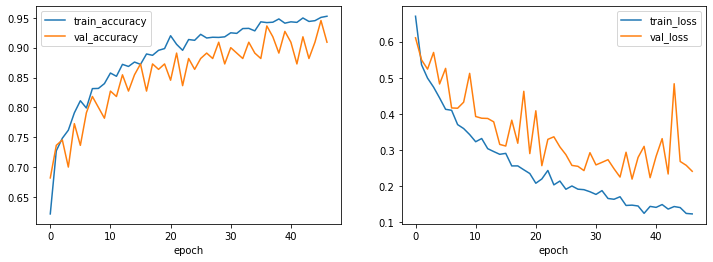

In [30]:
plot_loss_and_accuracy(history)

###Evaluation

In [31]:
valid_loss, valid_accuracy = model.evaluate_generator(validation_generator, steps=1)

Instructions for updating:
Please use Model.evaluate, which supports generators.


/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


In [32]:
print('valid loss : ', valid_loss, ', accuracy : ', valid_accuracy)

valid loss :  0.21948765218257904 , accuracy :  0.9363636374473572


In [0]:
y_valid = validation_generator.labels

In [34]:
y_valid_probas = model.predict_generator(validation_generator, steps=1)

Instructions for updating:
Please use Model.predict, which supports generators.


/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


In [0]:
y_valid_one = []
y_valid_zero = []
for i, x in enumerate(y_valid_probas):
  if y_valid[i] == 1:
    y_valid_one.append(x[0])
  else :
    y_valid_zero.append(x[0])

(array([24.,  5.,  5.,  2.,  2.,  0.,  2.,  1.,  0.,  0.,  2.,  0.,  0.,
         0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  1.,  1.,  1.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.]),
 array([3.78096661e-06, 1.44878775e-02, 2.89719738e-02, 4.34560701e-02,
        5.79401664e-02, 7.24242628e-02, 8.69083554e-02, 1.01392455e-01,
        1.15876548e-01, 1.30360648e-01, 1.44844741e-01, 1.59328833e-01,
        1.73812941e-01, 1.88297033e-01, 2.02781126e-01, 2.17265218e-01,
        2.31749326e-01, 2.46233419e-01, 2.60717511e-01, 2.75201619e-01,
        2.89685696e-01, 3.04169804e-01, 3.18653911e-01, 3.33137989e-01,
        3.47622097e-01, 3.62106174e-01, 3.76590282e-01, 3.91074389e-01,
        4.05558467e-01, 4.20042574e-01, 4.34526682e-01, 4.49010760e-01,
        4.63494867e-01, 4.77978945e-01, 4.92463052e-01, 5.06947160e-01,
        5.21431267e-01, 5.35915315e-01, 5.50399423e-01, 5.64883530e-

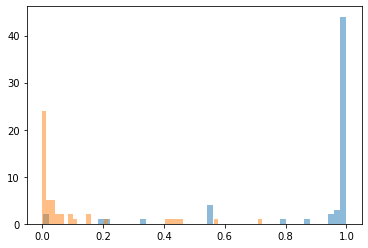

In [36]:
plt.hist(y_valid_one, bins=50, alpha=0.5)
plt.hist(y_valid_zero, bins=50, alpha=0.5)

###Save

In [0]:
# save the model
filename = '/content/drive/My Drive/my_model.h5'
model.save(filename)

###Extract images

In [0]:
def extract_images(input_directry, output_directry, threshold=0.9):
  output_directry_real = output_directry+'/real/'
  output_directry_fake = output_directry+'/fake/'
  if not os.path.exists(output_directry):
    subprocess.call('mkdir '+output_directry, shell=True)
  if not os.path.exists(output_directry_real):
    subprocess.call('mkdir '+output_directry_real, shell=True)
  if not os.path.exists(output_directry_fake):
    subprocess.call('mkdir '+output_directry_fake, shell=True)

  for i, file in enumerate(glob.glob(input_directry+'*.*')):
    print(file)
    image =load_img(file, grayscale=True).resize((224, 224))
    array = img_to_array(image) / 255.
    prob = model.predict(np.array([array]))[0][0]
    print(f'file={file}, prob={prob}')

    if prob >= threshold:
      shutil.copy(file, output_directry_real)
    else:
      shutil.copy(file, output_directry_fake)

In [0]:
!mkdir img_extracted

In [40]:
extract_images(real_directry, './img_extracted/real')
extract_images(fake_directry, './img_extracted/fake')

./img_original/real/8.img_kp03.png
file=./img_original/real/8.img_kp03.png, prob=0.9999991655349731
./img_original/real/3.s-l400.jpg
file=./img_original/real/3.s-l400.jpg, prob=0.8801499605178833
./img_original/real/23.919d27f1009ca01e25b6a3a3697ae4da.png


/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/utils.py:104: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


file=./img_original/real/23.919d27f1009ca01e25b6a3a3697ae4da.png, prob=0.01656743511557579
./img_original/real/44.0c4cdba74d8cbbb43b4144f749a02006.jpg
file=./img_original/real/44.0c4cdba74d8cbbb43b4144f749a02006.jpg, prob=0.999778687953949
./img_original/real/75.g51583.jpg
file=./img_original/real/75.g51583.jpg, prob=0.9999936819076538
./img_original/real/19.NEOGDS-320276.jpg
file=./img_original/real/19.NEOGDS-320276.jpg, prob=0.9481850266456604
./img_original/real/49.7d2695584672711c056876a087284430154821bbr1-2048-1374v2_00.jpg
file=./img_original/real/49.7d2695584672711c056876a087284430154821bbr1-2048-1374v2_00.jpg, prob=0.9999217987060547
./img_original/real/39.4893743.jpg
file=./img_original/real/39.4893743.jpg, prob=0.999919056892395
./img_original/real/32.koupenchan.png
file=./img_original/real/32.koupenchan.png, prob=0.999883770942688
./img_original/real/12.sticker.png
file=./img_original/real/12.sticker.png, prob=0.9999974966049194
./img_original/real/19.GOODS-00347311.jpg
file

In [41]:
!ls img_extracted/real/real/ | wc -l

270


In [42]:
!ls img_extracted/real/fake/ | wc -l

27


In [43]:
!ls img_extracted/fake/real/ | wc -l

1


In [44]:
!ls img_extracted/fake/fake/ | wc -l

246


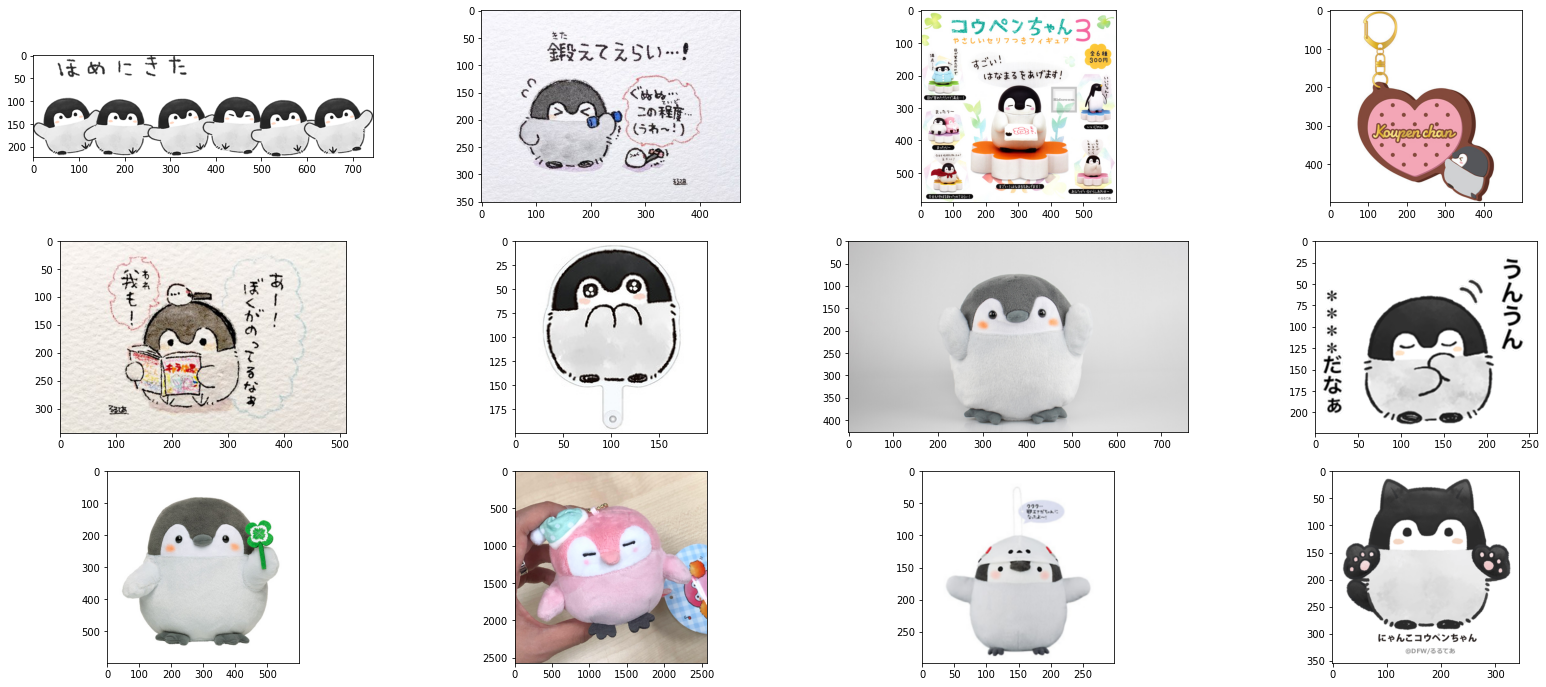

In [45]:
#true positive
show_images('./img_extracted/real/real/')

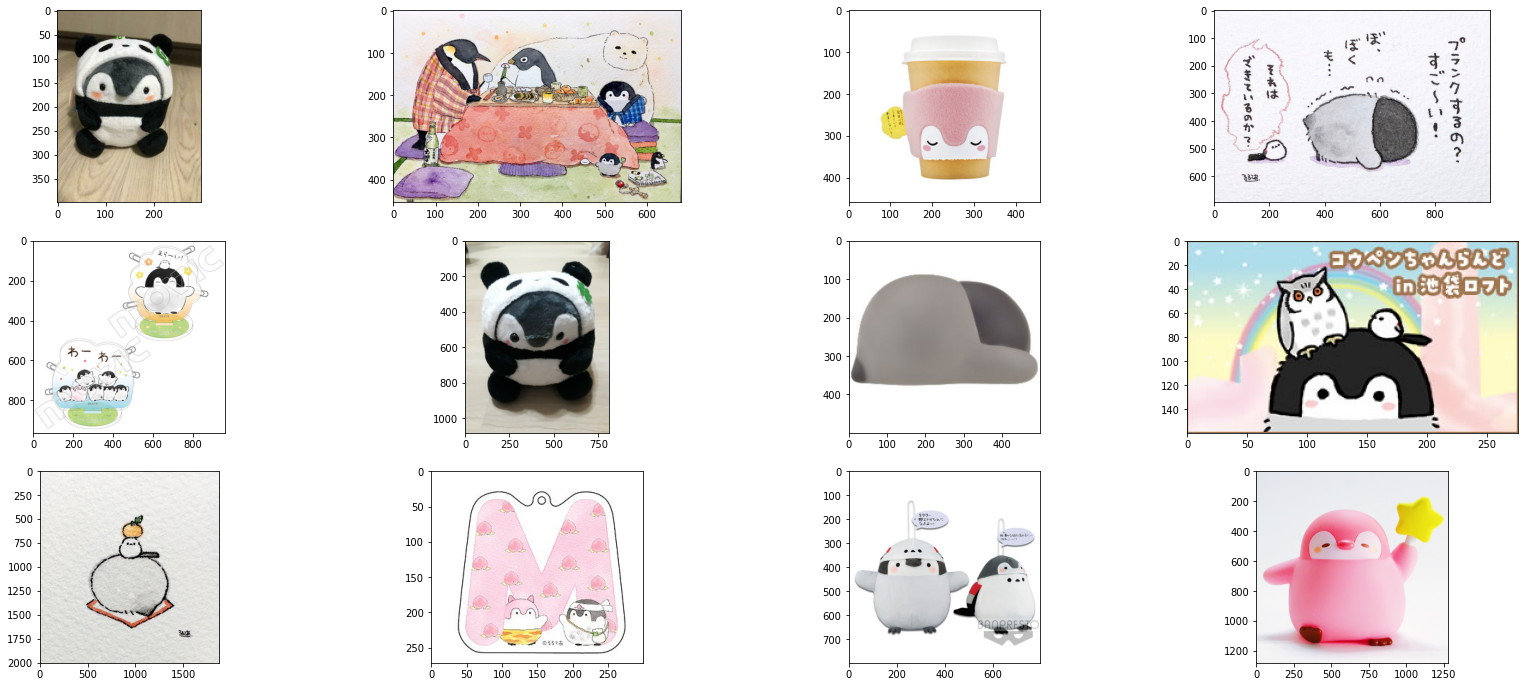

In [46]:
#false negative
show_images('./img_extracted/real/fake/')

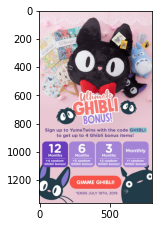

In [47]:
#false positive
show_images('./img_extracted/fake/real/')

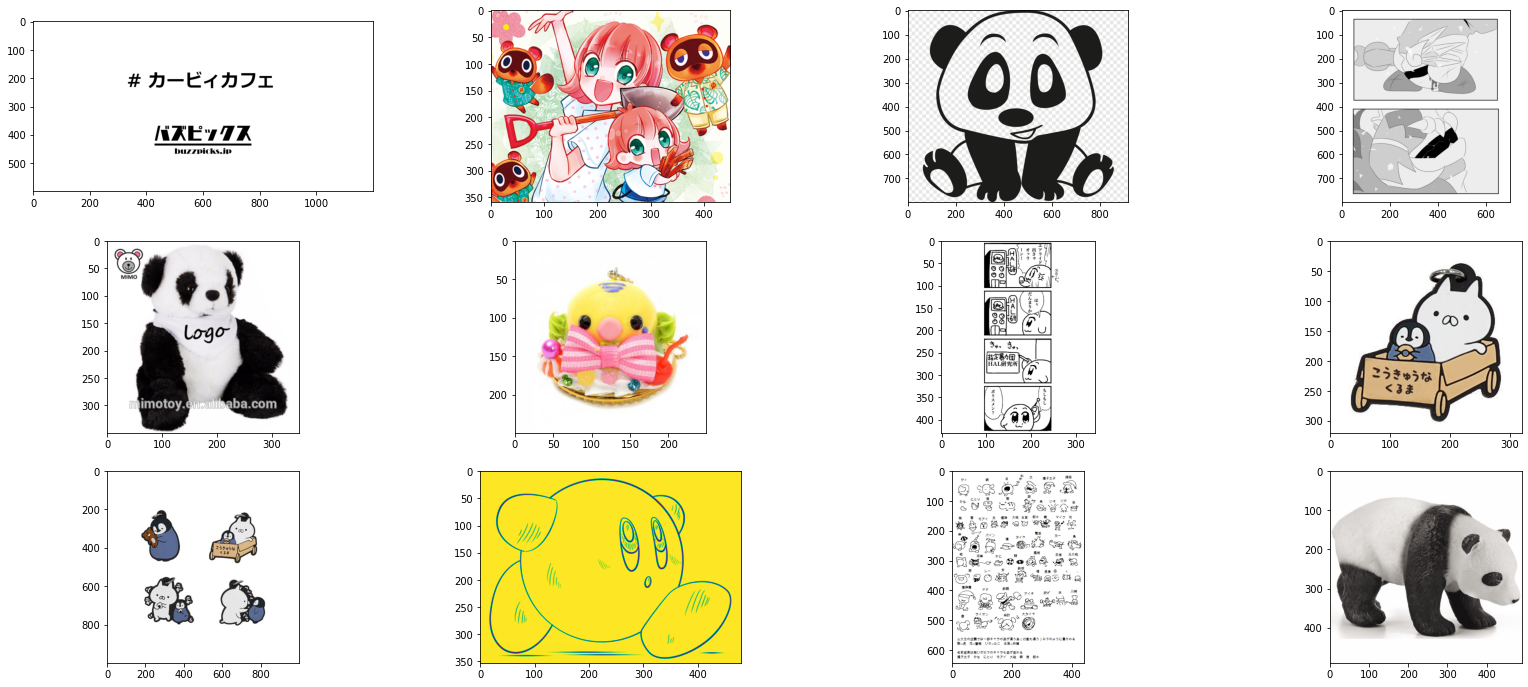

In [48]:
#true negative
show_images('./img_extracted/fake/fake/')

In [49]:
!zip -r /content/img_extracted.zip ./img_extracted

  adding: img_extracted/ (stored 0%)
  adding: img_extracted/real/ (stored 0%)
  adding: img_extracted/real/real/ (stored 0%)
  adding: img_extracted/real/real/8.img_kp03.png (deflated 0%)
  adding: img_extracted/real/real/44.0c4cdba74d8cbbb43b4144f749a02006.jpg (deflated 0%)
  adding: img_extracted/real/real/75.g51583.jpg (deflated 1%)
  adding: img_extracted/real/real/19.NEOGDS-320276.jpg (deflated 8%)
  adding: img_extracted/real/real/49.7d2695584672711c056876a087284430154821bbr1-2048-1374v2_00.jpg (deflated 0%)
  adding: img_extracted/real/real/39.4893743.jpg (deflated 2%)
  adding: img_extracted/real/real/32.koupenchan.png (deflated 0%)
  adding: img_extracted/real/real/12.sticker.png (deflated 1%)
  adding: img_extracted/real/real/19.GOODS-00347311.jpg (deflated 7%)
  adding: img_extracted/real/real/13.new_medium_size_sleeping_pink_koupen_chan_penguin_plush_soft_toy_keychain_1570607683_d810cd66_progressive.jpg (deflated 1%)
  adding: img_extracted/real/real/10.s-l300.png (deflate

In [0]:
files.download("./img_extracted.zip")